In [ ]:
# pip install opencv-python

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 as cv
from tqdm import tqdm

# Dataset

In [ ]:
# pip install kaggle

In [ ]:
# !kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset --unzip

In [111]:
def load_image_paths(base_dir, classes=['normal','tb']):
    rows = []
    for cls in classes:
        cls_dir = os.path.join(base_dir, cls)
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith(('.png','.jpg','.jpeg')):
                rows.append({'filepath': os.path.join(cls_dir,fname), 'label': cls})
    return pd.DataFrame(rows)

df = load_image_paths('TB_Chest_Radiography_Database', classes=['Normal','Tuberculosis'])
df

,filepath,label
0,TB_Chest_Radiography_Database\Normal\Normal-1.png,Normal
1,TB_Chest_Radiography_Database\Normal\Normal-10...,Normal
2,TB_Chest_Radiography_Database\Normal\Normal-10...,Normal
3,TB_Chest_Radiography_Database\Normal\Normal-10...,Normal
4,TB_Chest_Radiography_Database\Normal\Normal-10...,Normal
...,...,...
4195,TB_Chest_Radiography_Database\Tuberculosis\Tub...,Tuberculosis
4196,TB_Chest_Radiography_Database\Tuberculosis\Tub...,Tuberculosis
4197,TB_Chest_Radiography_Database\Tuberculosis\Tub...,Tuberculosis
4198,TB_Chest_Radiography_Database\Tuberculosis\Tub...,Tuberculosis


In [112]:
print("Normal counts: ", df[df['label'] == 'Normal'].shape[0])
print("TB counts: ", df[df['label'] == 'Tuberculosis'].shape[0])

Normal counts:  3500
TB counts:  700


In [113]:
def read_gray(path, size=(512,512)):
    img = cv.imread(path, cv.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f'failed open {path}')
    img = cv.resize(img, size)
    return img

In [114]:
path_normal = "/content/TB_Chest_Radiography_Database/Normal/"
path_tb     = "/content/TB_Chest_Radiography_Database/Tuberculosis/"

files_normal = sorted([f for f in os.listdir(path_normal) if f.lower().endswith(('.png','.jpg','.jpeg'))])
files_tb     = sorted([f for f in os.listdir(path_tb)     if f.lower().endswith(('.png','.jpg','.jpeg'))])

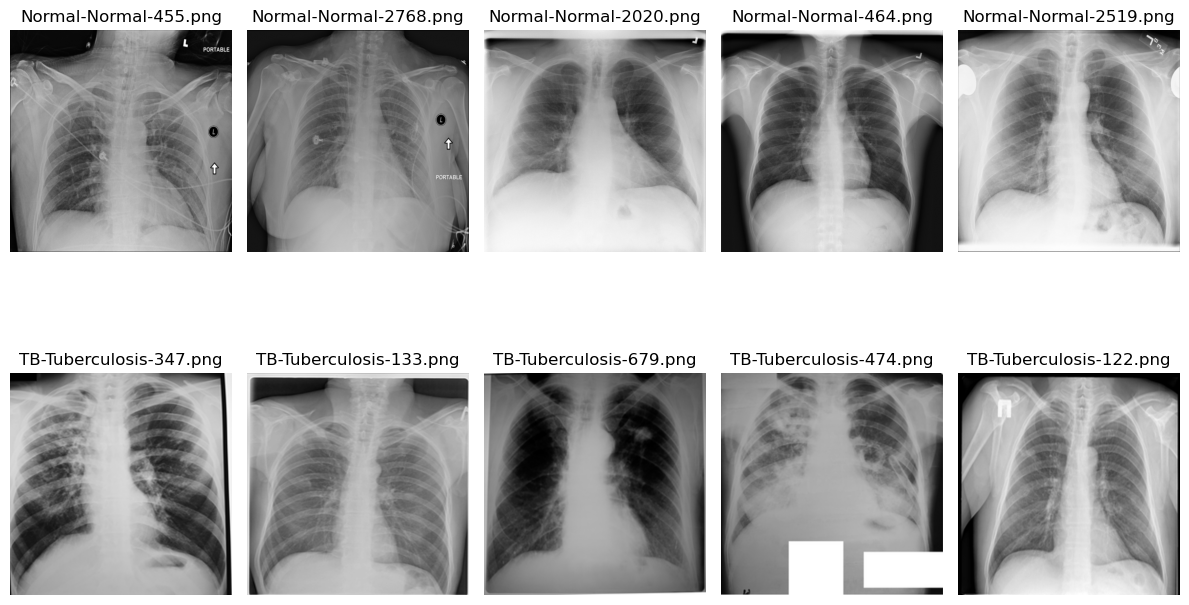

In [115]:
# img_normal = read_gray(path_normal+'/Normal-1.png')
# img_tb = read_gray(path_tb+'/Tuberculosis-1.png')

# print(img_normal.shape)
# print(img_tb.shape)
import os
import random

sample_normal = random.sample(files_normal, 5)
sample_tb = random.sample(files_tb, 5)

plt.figure(figsize=(12,8))

for i, fname in enumerate(sample_normal):
    img = read_gray(os.path.join(path_normal, fname))
    plt.subplot(2,5,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Normal-{fname}")
    plt.axis('off')

for i, fname in enumerate(sample_tb):
    img = read_gray(os.path.join(path_tb, fname))
    plt.subplot(2,5,5+i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"TB-{fname}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Enhancement

In [197]:
def noise_reduction(img):
    nlm = cv.fastNlMeansDenoising(
        img,
        h=10,
        templateWindowSize=7,
        searchWindowSize=21
    )
    return nlm

def clahe_enhancement(img):
    clahe = cv.createCLAHE(
        clipLimit=1.5,
        tileGridSize=(8,8)
    )
    clahe_img = clahe.apply(img)
    return clahe_img

# def contrast_stretch(img):
#     p2, p98 = np.percentile(img, (2, 98))
#     img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
#     return img_rescale

def gamma_correction(img, gamma=1.3):
    img_norm = img / 255.0
    img_gamma = np.power(img_norm, gamma)
    return (img_gamma * 255).astype(np.uint8)


In [ ]:
# def plot_hist(ax, img, title):
#     ax.hist(img.ravel(), bins=256, range=(0,255), color='black')
#     ax.set_title(title)
#     ax.set_xlabel("Intensity")
#     ax.set_ylabel("Frequency")

# fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# plot_hist(axes[0,0], img_normal, "Normal-Histogram")
# plot_hist(axes[0,1], nlm_normal, "After NLM Histogram")
# plot_hist(axes[0,2], clahe_normal, "After CLAHE Histogram")

# plot_hist(axes[1,0], img_tb, "TB-Histogram")
# plot_hist(axes[1,1], nlm_tb, "After NLM Histogram")
# plot_hist(axes[1,2], clahe_tb, "After CLAHE Histogram")

# plt.subplots_adjust(hspace=0.4)

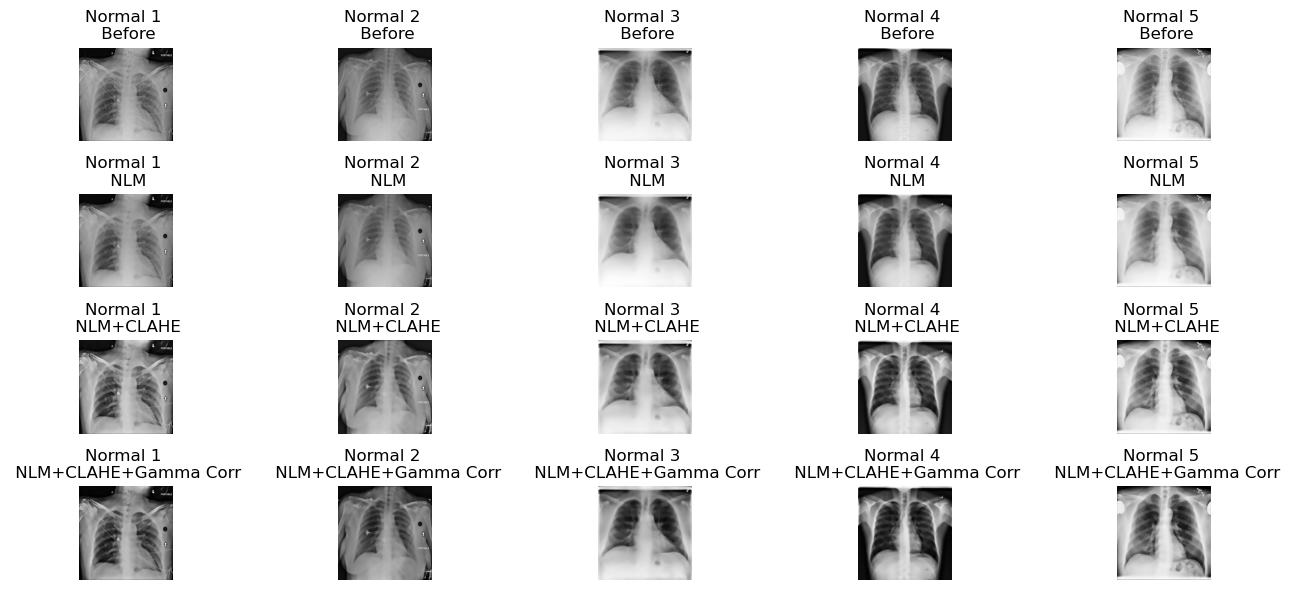

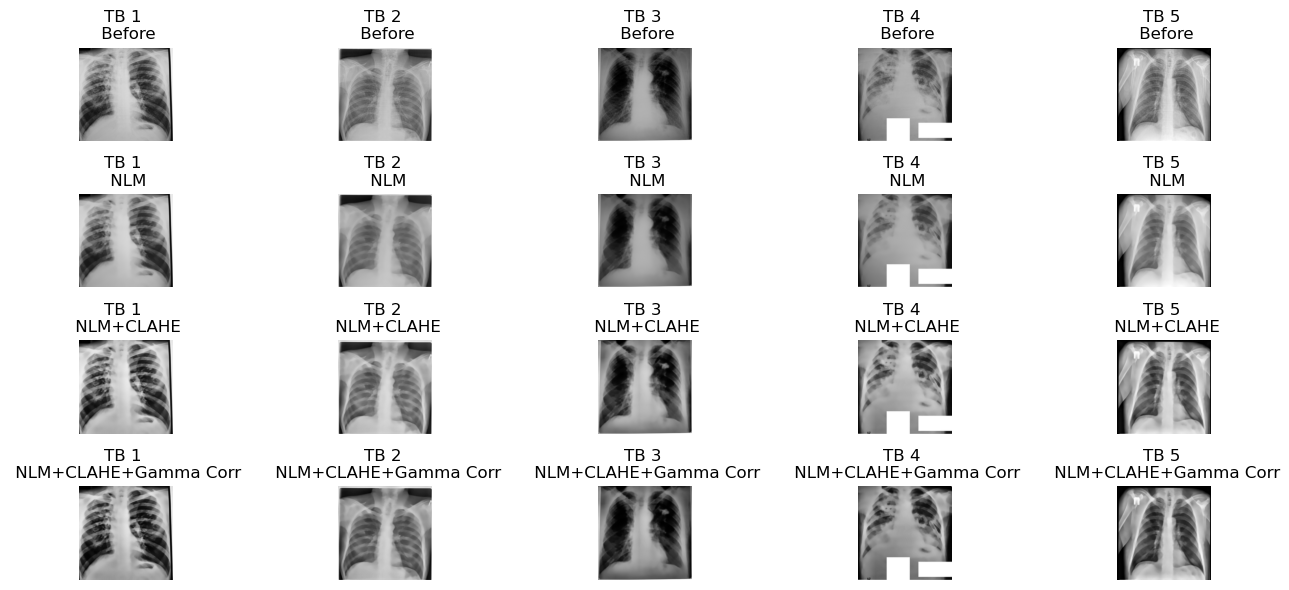

In [205]:
sample_processed = {
    "Normal": [],
    "TB": []
}

plt.figure(figsize=(14,6))

for i, fname in enumerate(sample_normal):
    img = read_gray(os.path.join(path_normal, fname))
    nlm = noise_reduction(img)
    clahe = clahe_enhancement(nlm)
    gamma = gamma_correction(clahe)

    # hasilnya disimpan untuk seluruh dataset
    sample_processed["Normal"].append({
        "filename": fname,
        "original": img,
        "nlm": nlm,
        "clahe": clahe,
        "gamma": gamma
    })

    # Before NLM
    plt.subplot(4,5,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Normal {i+1} \n Before")
    plt.axis('off')

    # NLM
    plt.subplot(4,5,5+i+1)
    plt.imshow(nlm, cmap='gray')
    plt.title(f"Normal {i+1} \n NLM")
    plt.axis('off')

    # NLM+CLAHE
    plt.subplot(4,5,10+i+1)
    plt.imshow(clahe, cmap='gray')
    plt.title(f"Normal {i+1} \n NLM+CLAHE")
    plt.axis('off')

    # NLM+CLAHE+Gamma Correction
    plt.subplot(4,5,15+i+1)
    plt.imshow(gamma, cmap='gray')
    plt.title(f"Normal {i+1} \n NLM+CLAHE+Gamma Corr")
    plt.axis('off')

plt.tight_layout()
plt.show()

plt.figure(figsize=(14,6))

for i, fname in enumerate(sample_tb):
    img = read_gray(os.path.join(path_tb, fname))
    nlm = noise_reduction(img)
    clahe = clahe_enhancement(nlm)
    gamma = gamma_correction(clahe)

    # hasilnya disimpan untuk seluruh dataset
    sample_processed["TB"].append({
        "filename": fname,
        "original": img,
        "nlm": nlm,
        "clahe": clahe,
        "gamma": gamma
    })

    # Before NLM
    plt.subplot(4,5,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"TB {i+1} \n Before")
    plt.axis('off')

    # NLM
    plt.subplot(4,5,5+i+1)
    plt.imshow(nlm, cmap='gray')
    plt.title(f"TB {i+1} \n NLM")
    plt.axis('off')

    # NLM+CLAHE
    plt.subplot(4,5,10+i+1)
    plt.imshow(clahe, cmap='gray')
    plt.title(f"TB {i+1} \n NLM+CLAHE")
    plt.axis('off')

    # NLM+CLAHE+Gamma Correction
    plt.subplot(4,5,15+i+1)
    plt.imshow(gamma, cmap='gray')
    plt.title(f"TB {i+1} \n NLM+CLAHE+Gamma Corr")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# processed = {
#     "Normal": [],
#     "TB": []
# }

# def process_folder(folder_path, file_list, label):
#     for fname in file_list:
#         full_path = os.path.join(folder_path, fname)

#         img = read_gray(full_path)
#         nlm = noise_reduction(img)
#         clahe_img = clahe.apply(nlm)

#         # hasilnya disimpan untuk seluruh dataset
#         processed[label].append({
#             "filename": fname,
#             "original": img,
#             "nlm": nlm,
#             "clahe": clahe_img
#         })

In [ ]:
# # normal
# process_folder(path_normal, files_normal, "Normal")

# # tb
# process_folder(path_tb, files_tb, "TB")

In [ ]:
# def show_examples(label):
#     samples = processed[label][:5]
#     fig, axes = plt.subplots(5, 4, figsize=(16, 14))
#     fig.suptitle(f"{label} — Original | NLM | NLM+CLAHE | Histogram", fontsize=16)

#     for i, item in enumerate(samples):
#         img      = item["original"]
#         nlm      = item["nlm"]
#         clahe_im = item["clahe"]

#         axes[i,0].imshow(img, cmap='gray'); axes[i,0].set_title("Original"); axes[i,0].axis("off")
#         axes[i,1].imshow(nlm, cmap='gray'); axes[i,1].set_title("NLM"); axes[i,1].axis("off")
#         axes[i,2].imshow(clahe_im, cmap='gray'); axes[i,2].set_title("NLM+CLAHE"); axes[i,2].axis("off")
#         axes[i,3].hist(clahe_im.ravel(), bins=256)
#         axes[i,3].set_title("Histogram")

#     plt.tight_layout()
#     plt.show()

# show_examples("Normal")
# show_examples("TB")

# Segmentation

In [199]:
from skimage import morphology, measure

def segment_lungs_refined(img):
    # Otsu
    thr_val, thr = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    thr = 255 - thr

    # Opening
    kernel_small = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,5))
    morph = cv.morphologyEx(thr, cv.MORPH_OPEN, kernel_small, iterations=2)

    # Hole Filling
    morph_bool = morphology.remove_small_holes(morph.astype(bool), area_threshold=30000)
    morph = (morph_bool * 255).astype(np.uint8)

    # Labeling & Sorting
    labels = measure.label(morph, connectivity=2)
    props = measure.regionprops(labels)
    props = sorted(props, key=lambda x: x.area, reverse=True)

    mask = np.zeros_like(img, dtype=np.uint8)
    for p in props[:2]:
        mask[labels == p.label] = 255

    # Closing
    kernel_large = cv.getStructuringElement(cv.MORPH_ELLIPSE, (20,20))
    mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel_large)

    segmented = cv.bitwise_and(img, img, mask=mask)
    return mask, segmented

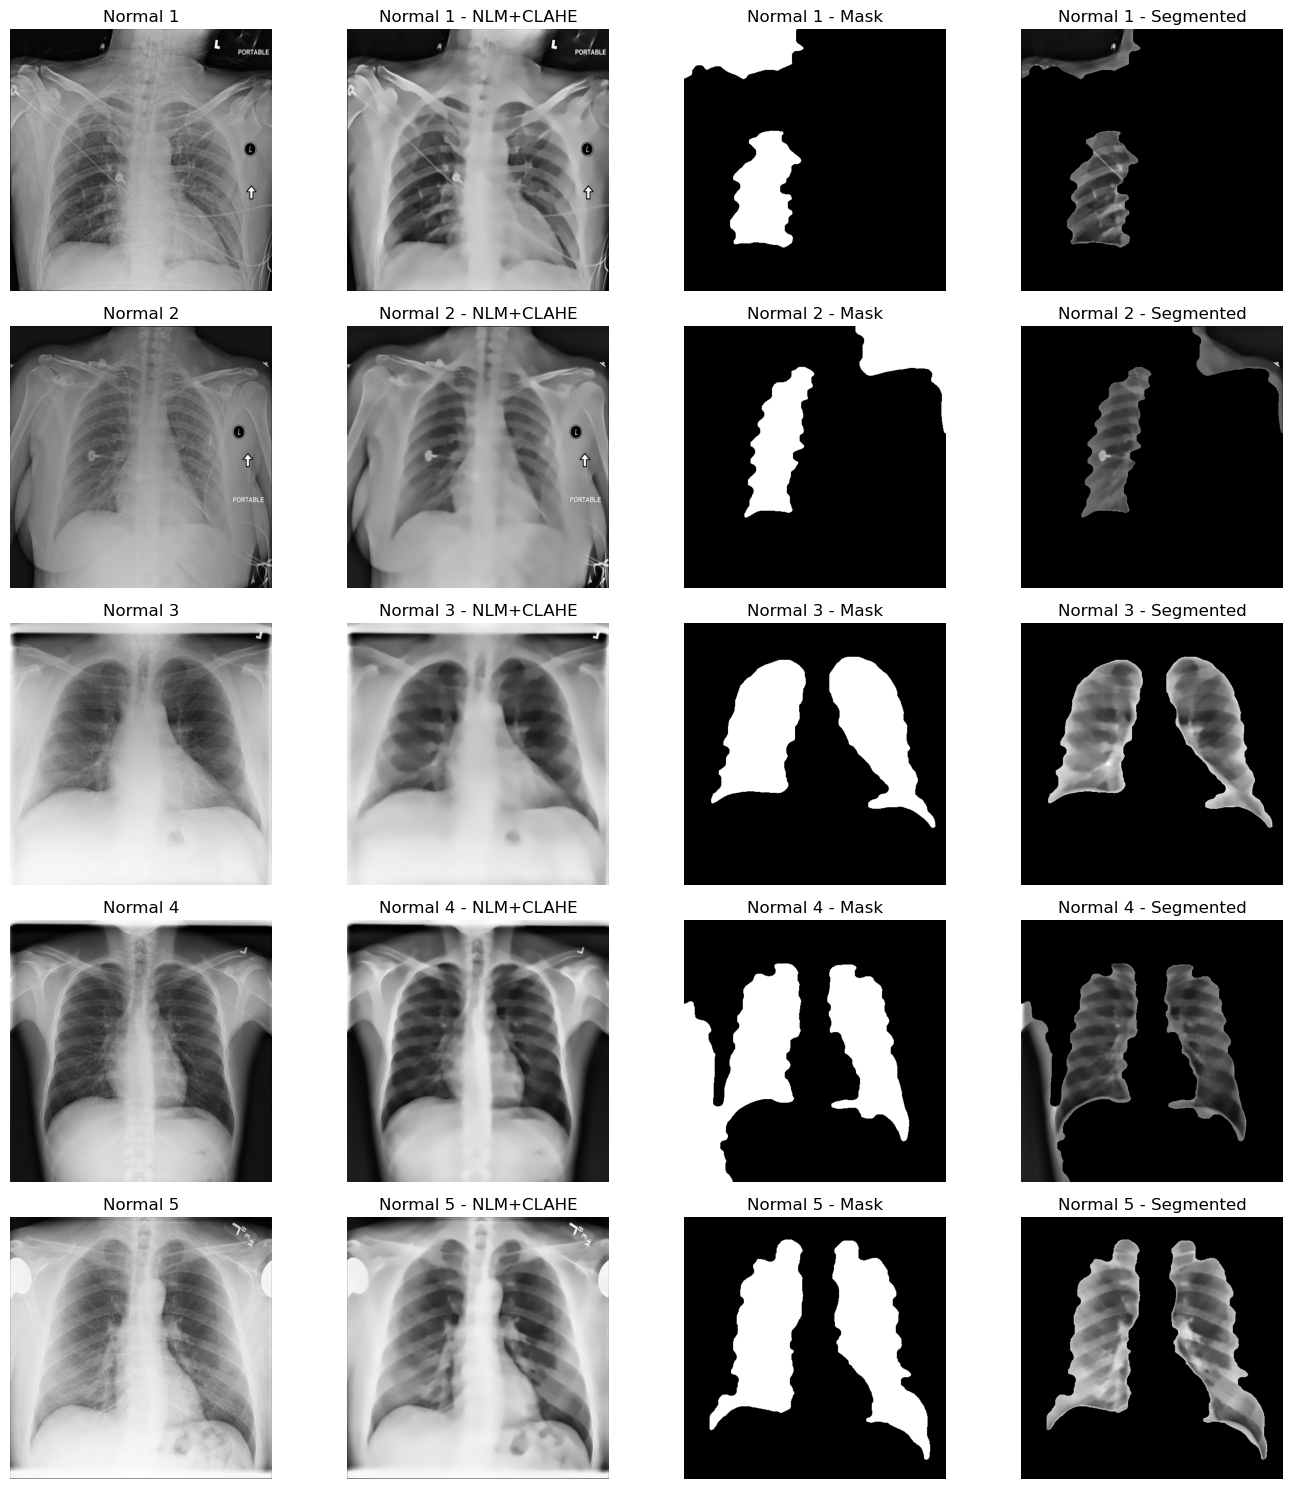

In [209]:
plt.figure(figsize=(14,15))

for i, data_dict in enumerate(sample_processed["Normal"]):
    
    processed_img = data_dict["clahe"]
    fname = data_dict["filename"]
    
    # Original
    img = read_gray(os.path.join(path_normal, fname)) 
    
    mask, seg = segment_lungs_refined(processed_img)
    
    # Original
    plt.subplot(5, 4, 4*i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Normal {i+1}")
    plt.axis('off')

    # Enhanced (NLM+CLAHE)
    plt.subplot(5, 4, 4*i + 2)
    plt.imshow(processed_img, cmap='gray')
    plt.title(f"Normal {i+1} - NLM+CLAHE")
    plt.axis('off')

    # Mask
    plt.subplot(5, 4, 4*i + 3)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Normal {i+1} - Mask")
    plt.axis('off')

    # Segmented
    plt.subplot(5, 4, 4*i + 4)
    plt.imshow(seg, cmap='gray')
    plt.title(f"Normal {i+1} - Segmented")
    plt.axis('off')

plt.tight_layout()
plt.show()

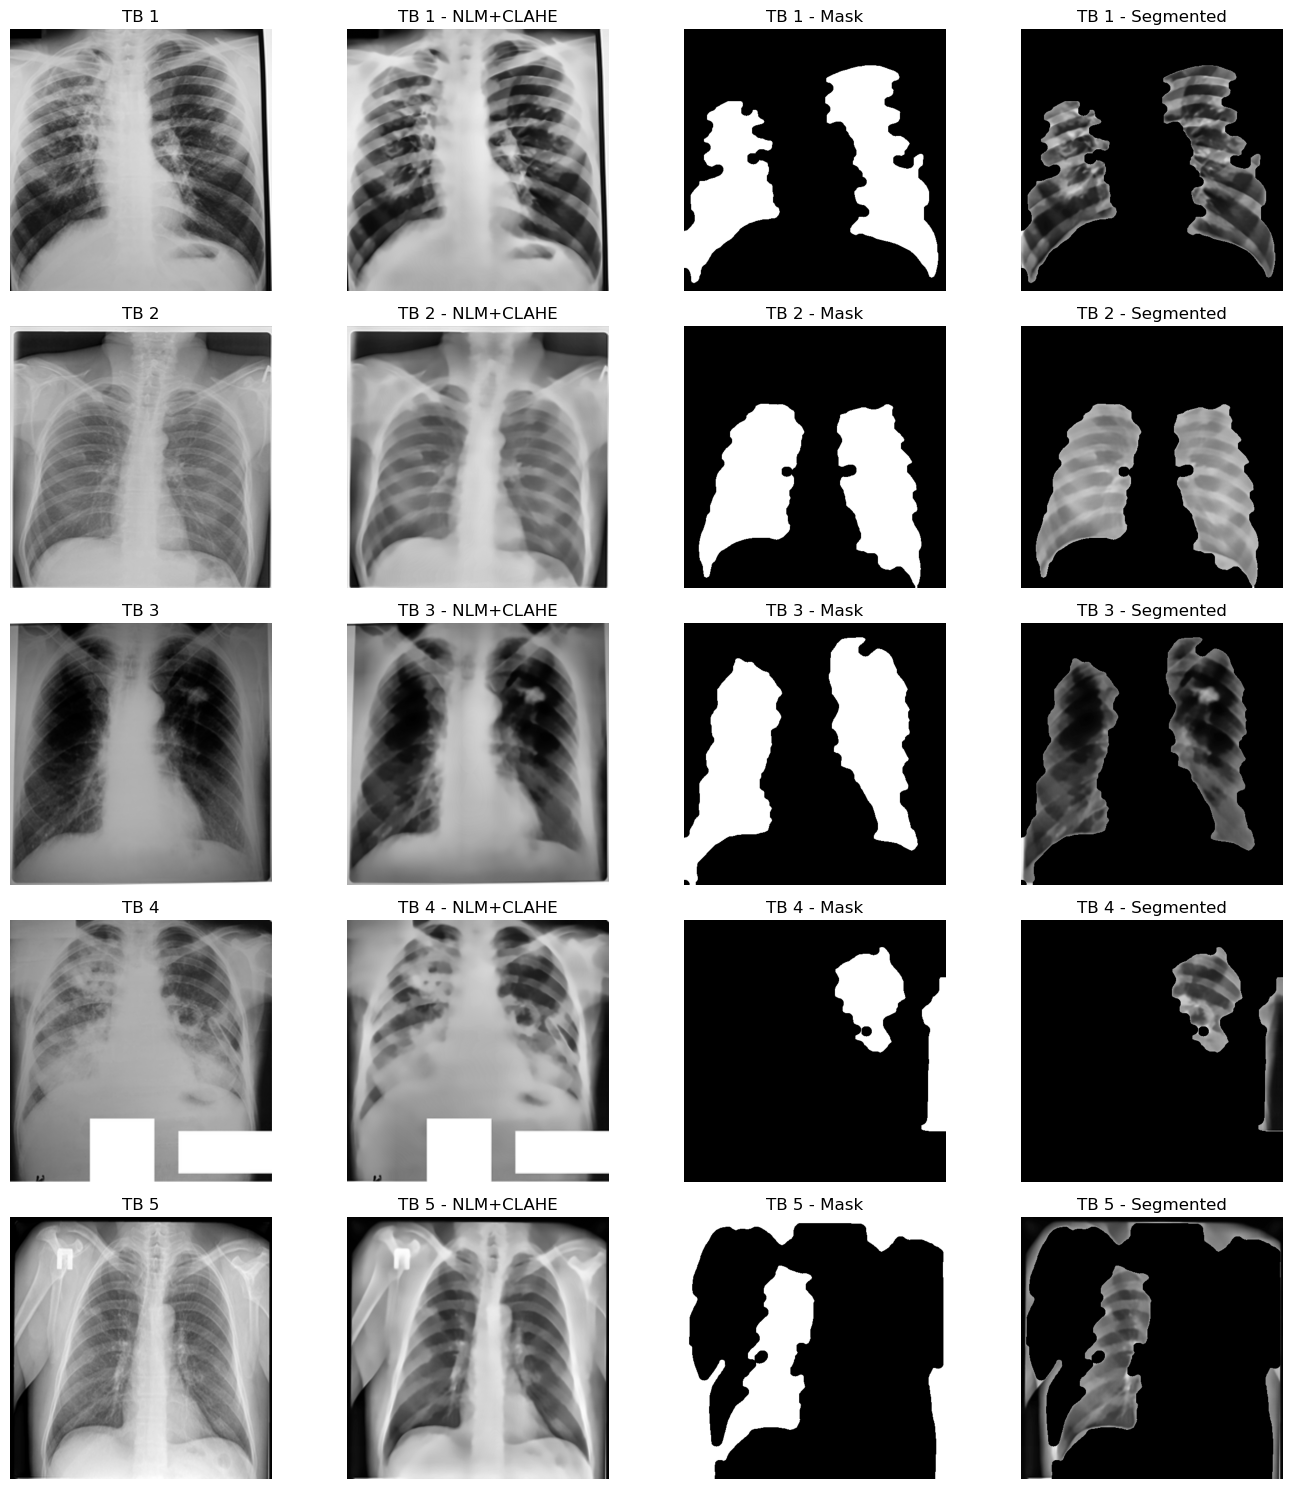

In [210]:
plt.figure(figsize=(14,15))

for i, data_dict in enumerate(sample_processed["TB"]):
    
    processed_img = data_dict["clahe"]
    fname = data_dict["filename"]
    
    # Original
    img = read_gray(os.path.join(path_tb, fname))
    
    mask, seg = segment_lungs_refined(processed_img)

    # Original
    plt.subplot(5, 4, 4*i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"TB {i+1}")
    plt.axis('off')

    # Enhanced (NLM+CLAHE)
    plt.subplot(5, 4, 4*i + 2)
    plt.imshow(processed_img, cmap='gray')
    plt.title(f"TB {i+1} - NLM+CLAHE")
    plt.axis('off')

    # Mask
    plt.subplot(5, 4, 4*i + 3)
    plt.imshow(mask, cmap='gray')
    plt.title(f"TB {i+1} - Mask")
    plt.axis('off')

    # Segmented
    plt.subplot(5, 4, 4*i + 4)
    plt.imshow(seg, cmap='gray')
    plt.title(f"TB {i+1} - Segmented")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# processed = {
#     "Normal": [],
#     "TB": []
# }

# def process_folder(folder_path, file_list, label):
#     for fname in file_list:
#         full_path = os.path.join(folder_path, fname)

#         img = read_gray(full_path)
#         nlm = noise_reduction(img)
#         clahe_img = clahe.apply(nlm)
#         mask, lung_seg = segment_lungs(clahe_img)
#         processed[label].append({
#             "filename": fname,
#             "original": img,
#             "nlm": nlm,
#             "clahe": clahe_img,
#             "lung_mask": mask,
#             "lung_segmented": lung_seg
#         })

# # normal
# process_folder(path_normal, files_normal, "Normal")

# # tb
# process_folder(path_tb, files_tb, "TB")

In [ ]:
# processed = {
#     "Normal": [],
#     "TB": []
# }

# def process_folder(folder_path, file_list, label):
#     for fname in file_list:
#         full_path = os.path.join(folder_path, fname)

#         img = read_gray(full_path)
#         nlm = noise_reduction(img)
#         clahe_img = clahe.apply(nlm)
#         mask, lung_seg = segment_lungs(nlm)
#         processed[label].append({
#             "filename": fname,
#             "original": img,
#             "nlm": nlm,
#             "clahe": clahe_img,
#             "lung_mask": mask,
#             "lung_segmented": lung_seg
#         })

# # normal
# process_folder(path_normal, files_normal, "Normal")

# # tb
# process_folder(path_tb, files_tb, "TB")

In [ ]:
# def show_examples(label):
#     samples = processed[label][:5]
#     fig, axes = plt.subplots(5, 5, figsize=(16, 14))
#     fig.suptitle(f"{label} — Original | NLM | NLM+CLAHE | Lung Mask | Lung Segmented", fontsize=16)

#     for i, item in enumerate(samples):
#         img      = item["original"]
#         nlm      = item["nlm"]
#         clahe_im = item["clahe"]
#         lung_mask = item["lung_mask"]
#         lung_segmented = item["lung_segmented"]

#         axes[i,0].imshow(img, cmap='gray'); axes[i,0].set_title("Original"); axes[i,0].axis("off")
#         axes[i,1].imshow(nlm, cmap='gray'); axes[i,1].set_title("NLM"); axes[i,1].axis("off")
#         axes[i,2].imshow(clahe_im, cmap='gray'); axes[i,2].set_title("NLM+CLAHE"); axes[i,2].axis("off")
#         axes[i,3].imshow(lung_mask, cmap='gray'); axes[i,3].set_title("Lung Mask"); axes[i,3].axis("off")
#         axes[i,4].imshow(lung_segmented, cmap='gray'); axes[i,4].set_title("Lung Segmented"); axes[i,4].axis("off")
#         # axes[i,3].hist(clahe_im.ravel(), bins=256)
#         # axes[i,3].set_title("Histogram")

#     plt.tight_layout()
#     plt.show()

# show_examples("Normal")
# show_examples("TB")

# Feature Extraction